# Adapter :: LoRA
- Ref: 
    - https://huggingface.co/docs/diffusers/v0.34.0/en/tutorials/using_peft_for_inference
    - https://huggingface.co/docs/diffusers/v0.34.0/en/training/lora
    


## 0. Configure device

In [1]:
#@title
import torch

if torch.backends.mps.is_available():
    t_device = torch.device("mps")
    s_device = "mps"
    print(f"Current memory allocated on MPS: {torch.mps.current_allocated_memory()} bytes")
    print(f"Driver memory allocated on MPS: {torch.mps.driver_allocated_memory()} bytes")
    if torch.mps.driver_allocated_memory() - torch.mps.current_allocated_memory()< 1e4:
        print("Not enough mps memory, convert to cpu mode")
        t_device = torch.device("cpu")
        s_device = "cpu"
elif torch.cuda.is_available():
    t_device = torch.device("cuda")
    s_device = "cuda"
else:
    t_device = torch.device("cpu")
    s_device = "cpu"
print(t_device)

cuda


### 0. LoRA

#### 0.1 text-to-Image

model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

config.json: 0.00B [00:00, ?B/s]

preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

pytorch_lora_weights.safetensors:   0%|          | 0.00/3.23M [00:00<?, ?B/s]

No LoRA keys associated to UNet2DConditionModel found with the prefix='unet'. This is safe to ignore if LoRA state dict didn't originally have any UNet2DConditionModel related params. You can also try specifying `prefix=None` to resolve the warning. Otherwise, open an issue if you think it's unexpected: https://github.com/huggingface/diffusers/issues/new
No LoRA keys associated to CLIPTextModel found with the prefix='text_encoder'. This is safe to ignore if LoRA state dict didn't originally have any CLIPTextModel related params. You can also try specifying `prefix=None` to resolve the warning. Otherwise, open an issue if you think it's unexpected: https://github.com/huggingface/diffusers/issues/new


  0%|          | 0/50 [00:00<?, ?it/s]

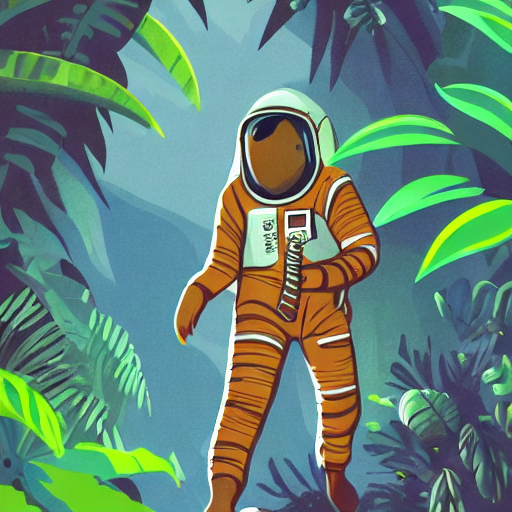

In [3]:
from diffusers import DiffusionPipeline

pipe = DiffusionPipeline.from_pretrained("runwayml/stable-diffusion-v1-5")
pipe.load_lora_weights("juliensimon/stable-diffusion-v1-5-pokemon-lora")

prompt = "Astronaut in a jungle, cold color palette, muted colors, detailed, 8k"
pipe(prompt).images[0]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .
No LoRA keys associated to CLIPTextModel found with the prefix='text_encoder'. This is safe to ignore if LoRA state dict didn't originally have any CLIPTextModel related params. You can also try specifying `prefix=None` to resolve the warning. Otherwise, open an issue if you think it's unexpected: https://github.com/huggingface/diffusers/issues/n

  0%|          | 0/50 [00:00<?, ?it/s]

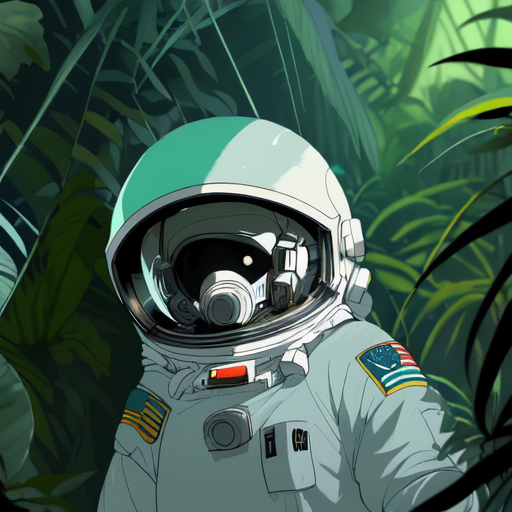

In [5]:
from diffusers import DiffusionPipeline

pipe = DiffusionPipeline.from_pretrained("nqzfaizal77ai/austersight-exp-sd-1.5").to(t_device)
pipe.load_lora_weights("nqzfaizal77ai/sibear-sd-1.5-lora")

prompt = "Astronaut in a jungle, cold color palette, muted colors, detailed, 8k"
pipe(prompt).images[0]

## 1.torch.compile

In [ ]:
import torch
from diffusers import DiffusionPipeline

# load base model and LoRA
# pipeline = DiffusionPipeline.from_pretrained(
#     "stabilityai/stable-diffusion-xl-base-1.0",
#     torch_dtype=torch.float16
# ).to(t_device)
# pipeline.load_lora_weights(
#     "ostris/ikea-instructions-lora-sdxl",
#     weight_name="ikea_instructions_xl_v1_5.safetensors",
#     adapter_name="ikea"
# )

pipeline = DiffusionPipeline.from_pretrained("nqzfaizal77ai/austersight-exp-sd-1.5").to(t_device)
pipeline.load_lora_weights(
    "nqzfaizal77ai/sibear-sd-1.5-lora",
    adapter_name="sibear")

# activate LoRA and set adapter weight
pipeline.set_adapters("sibear", adapter_weights=0.7)

# fuse LoRAs and unload weights
pipeline.fuse_lora(adapter_names=["sibear"], lora_scale=1.0)
pipeline.unload_lora_weights()

pipeline.unet.to(memory_format=torch.channels_last)

# - MPS could not support torch.compile
pipeline.unet = torch.compile(pipeline.unet, mode="reduce-overhead", fullgraph=True)

image = pipeline("A bowl of ramen shaped like a cute kawaii bear").images[0]

### -- Does not work on MacOS :: "torch.compile"

del pipeline

import torch

import gc
gc.collect()
torch.cuda.empty_cache()

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .
No LoRA keys associated to CLIPTextModel found with the prefix='text_encoder'. This is safe to ignore if LoRA state dict didn't originally have any CLIPTextModel related params. You can also try specifying `prefix=None` to resolve the warning. Otherwise, open an issue if you think it's unexpected: https://github.com/huggingface/diffusers/issues/n

  0%|          | 0/50 [00:00<?, ?it/s]

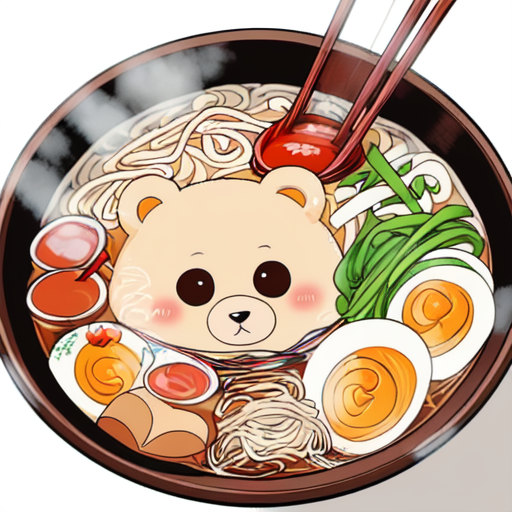

In [4]:
image

### 2.Weight Scale


#### 2.1 Simple use case

In [5]:
from diffusers import DiffusionPipeline

pipe = DiffusionPipeline.from_pretrained("runwayml/stable-diffusion-v1-5").to(t_device)
pipe.load_lora_weights("juliensimon/stable-diffusion-v1-5-pokemon-lora", adapter_name="pokemon")

prompt = "Astronaut in a jungle, cold color palette, muted colors, detailed, 8k"
img1 = pipe(prompt).images[0]

img2 = pipe("bears, pizza bites", cross_attention_kwargs={"scale": 1.0}).images[0]

del pipe

import torch

import gc
gc.collect()
torch.cuda.empty_cache()

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

No LoRA keys associated to UNet2DConditionModel found with the prefix='unet'. This is safe to ignore if LoRA state dict didn't originally have any UNet2DConditionModel related params. You can also try specifying `prefix=None` to resolve the warning. Otherwise, open an issue if you think it's unexpected: https://github.com/huggingface/diffusers/issues/new
No LoRA keys associated to CLIPTextModel found with the prefix='text_encoder'. This is safe to ignore if LoRA state dict didn't originally have any CLIPTextModel related params. You can also try specifying `prefix=None` to resolve the warning. Otherwise, open an issue if you think it's unexpected: https://github.com/huggingface/diffusers/issues/new


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

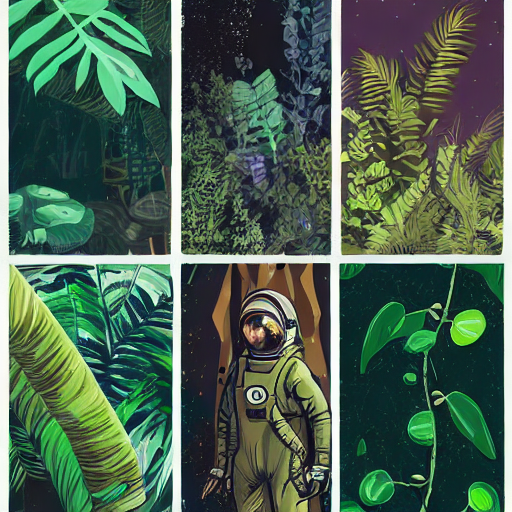

In [6]:
img1

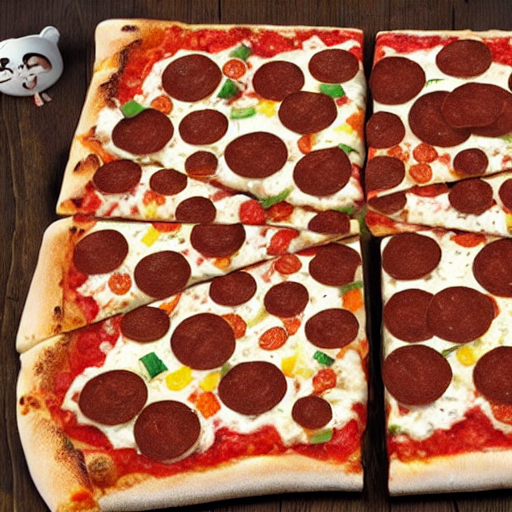

In [7]:
img2


#### 2.2. Fine Controls


In [ ]:
pipeline = DiffusionPipeline.from_pretrained("nqzfaizal77ai/austersight-exp-sd-1.5").to(t_device)
pipeline.load_lora_weights(
    "nqzfaizal77ai/sibear-sd-1.5-lora",
    adapter_name="sibear")

# activate LoRA and set adapter weight
pipeline.set_adapters("sibear", adapter_weights=0.7)

scales = {
    "text_encoder": 0.5,
    "text_encoder_2": 0.5,
    "unet": {
        "down": 0.9,
        "up": {
            "block_0": 0.6,
            "block_1": [0.4, 0.8, 1.0],
        }
    }
}
pipeline.set_adapters("sibear", scales)
img = pipeline("bears, pizza bites").images[0]

del pipeline

import torch

import gc
gc.collect()
torch.cuda.empty_cache()

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .
No LoRA keys associated to CLIPTextModel found with the prefix='text_encoder'. This is safe to ignore if LoRA state dict didn't originally have any CLIPTextModel related params. You can also try specifying `prefix=None` to resolve the warning. Otherwise, open an issue if you think it's unexpected: https://github.com/huggingface/diffusers/issues/n

  0%|          | 0/50 [00:00<?, ?it/s]

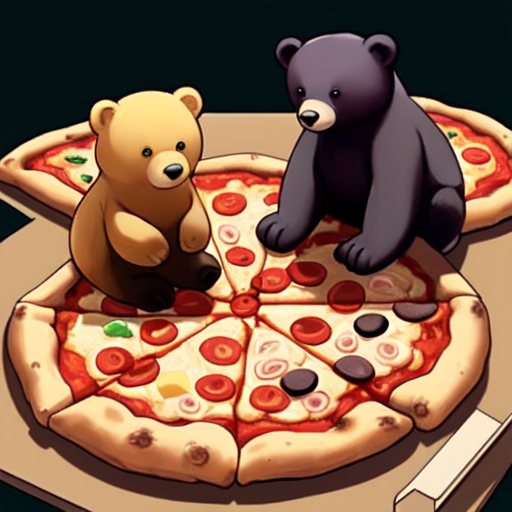

In [11]:
img

#### 2.3 Sacle scheduling

In [13]:
##  Does not work

import torch
from diffusers import FluxPipeline

# pipeline = FluxPipeline.from_pretrained(
#     "black-forest-labs/FLUX.1-dev", torch_dtype=torch.bfloat16
# ).to(t_device)

# pipelne.load_lora_weights("alvarobartt/ghibli-characters-flux-lora", "lora")

pipeline = DiffusionPipeline.from_pretrained("nqzfaizal77ai/austersight-exp-sd-1.5").to(t_device)
pipeline.load_lora_weights(
    "nqzfaizal77ai/sibear-sd-1.5-lora", "lora")

num_inference_steps = 30
lora_steps = 20
lora_scales = torch.linspace(1.5, 0.7, lora_steps).tolist()
lora_scales += [0.2] * (num_inference_steps - lora_steps + 1)

pipeline.set_adapters("lora", lora_scales[0])

def callback(pipeline: FluxPipeline, step: int, timestep: torch.LongTensor, callback_kwargs: dict):
    pipeline.set_adapters("lora", lora_scales[step + 1])
    return callback_kwargs

prompt = """
Ghibli style The Grinch, a mischievous green creature with a sly grin, peeking out from behind a snow-covered tree while plotting his antics,
in a quaint snowy village decorated for the holidays, warm light glowing from cozy homes, with playful snowflakes dancing in the air
"""
img = pipeline(
    prompt=prompt,
    guidance_scale=3.0,
    num_inference_steps=num_inference_steps,
    generator=torch.Generator().manual_seed(42),
    callback_on_step_end=callback,
).images[0]


del pipeline

import torch

import gc

gc.collect()
torch.cuda.empty_cache()

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .
No LoRA keys associated to CLIPTextModel found with the prefix='text_encoder'. This is safe to ignore if LoRA state dict didn't originally have any CLIPTextModel related params. You can also try specifying `prefix=None` to resolve the warning. Otherwise, open an issue if you think it's unexpected: https://github.com/huggingface/diffusers/issues/n

  0%|          | 0/30 [00:00<?, ?it/s]

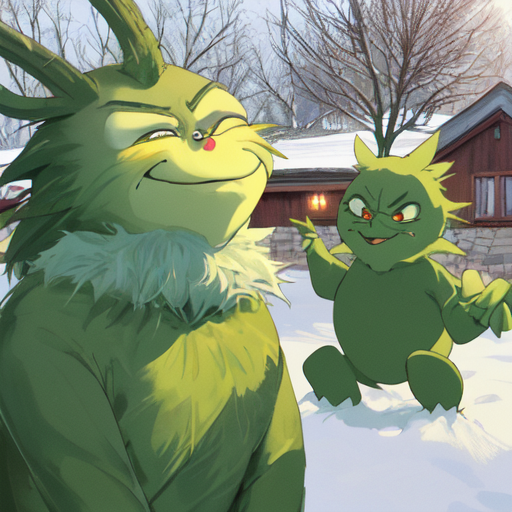

In [15]:
img

### 3. Hotswapping

In [ ]:
import torch
from diffusers import DiffusionPipeline

# load base model and LoRAs
pipeline = DiffusionPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0",
    torch_dtype=torch.float16
).to(t_device)
pipeline.load_lora_weights(
    "ostris/ikea-instructions-lora-sdxl",
    weight_name="ikea_instructions_xl_v1_5.safetensors",
    adapter_name="ikea"
)

In [ ]:
pipeline.load_lora_weights(
    "lordjia/by-feng-zikai",
    hotswap=True,
    adapter_name="ikea"
)

#### 3.1 Compile models

In [ ]:
import torch
from diffusers import DiffusionPipeline

# load base model and LoRAs
pipeline = DiffusionPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0",
    torch_dtype=torch.float16
).to(t_device)

# 1. enable_lora_hotswap
max_rank = 128
pipeline.enable_lora_hotswap(target_rank=max_rank)
pipeline.load_lora_weights(
    "ostris/ikea-instructions-lora-sdxl",
    weight_name="ikea_instructions_xl_v1_5.safetensors",
    adapter_name="ikea"
)

# 2. torch.compile
# - torch.compile does not work with MPS
pipeline.unet = torch.compile(pipeline.unet,
                              mode="reduce-overhead",
                              fullgraph=True)

# 3. hotswap
pipeline.load_lora_weights(
    "lordjia/by-feng-zikai",
    # hotswap=True,
    adapter_name="ikea_0"
)

pipeline("A bowl of ramen shaped like a cute kawaii bear").images[0]


del pipeline

import torch

import gc
gc.collect()
torch.cuda.empty_cache()



### 4. Merge

#### 4.1 set_adapter

In [ ]:
from diffusers import DiffusionPipeline

pipeline = DiffusionPipeline.from_pretrained(
    "nqzfaizal77ai/austersight-exp-sd-1.5").to(t_device)
pipeline.load_lora_weights(
    "nqzfaizal77ai/busipa-sd-1.5-lora",
    adapter_name="busipa")
pipeline.load_lora_weights(
    "nqzfaizal77ai/sibear-sd-1.5-lora",
    adapter_name="sibear")




Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .
No LoRA keys associated to CLIPTextModel found with the prefix='text_encoder'. This is safe to ignore if LoRA state dict didn't originally have any CLIPTextModel related params. You can also try specifying `prefix=None` to resolve the warning. Otherwise, open an issue if you think it's unexpected: https://github.com/huggingface/diffusers/issues/n

  0%|          | 0/50 [00:00<?, ?it/s]

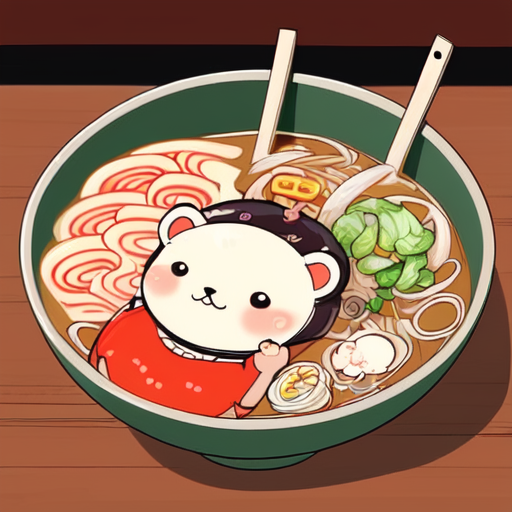

In [5]:
pipeline.set_adapters(["busipa", "sibear"], adapter_weights=[0.7, 0.8])
# use by Feng Zikai to activate the lordjia/by-feng-zikai LoRA
pipeline("A bowl of ramen shaped like a cute kawaii bear, by Feng Zikai", cross_attention_kwargs={"scale": 1.0}).images[0]

In [9]:
del pipeline

import torch

import gc
gc.collect()
torch.cuda.empty_cache()

#### 4.2 add_weighted_adapter

- Does not work on Mac

In [11]:
import copy
import torch
from diffusers import AutoModel, DiffusionPipeline
from peft import get_peft_model, LoraConfig, PeftModel

unet = AutoModel.from_pretrained(
    "nqzfaizal77ai/austersight-exp-sd-1.5",
    torch_dtype=torch.float16,
    use_safetensors=True,
    subfolder="unet",
).to(t_device)

diffusion_pytorch_model.safetensors:   0%|          | 0.00/1.72G [00:00<?, ?B/s]

In [13]:
pipeline = DiffusionPipeline.from_pretrained(
    "nqzfaizal77ai/austersight-exp-sd-1.5",
    torch_dtype=torch.float16,
    unet=unet
).to(t_device)
pipeline.load_lora_weights(
    "nqzfaizal77ai/busipa-sd-1.5-lora",
    adapter_name="busipa"
)

Fetching 11 files:   0%|          | 0/11 [00:00<?, ?it/s]

scheduler_config.json:   0%|          | 0.00/870 [00:00<?, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

preprocessor_config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/735 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/246M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/764 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


pytorch_lora_weights.safetensors:   0%|          | 0.00/6.41M [00:00<?, ?B/s]

No LoRA keys associated to CLIPTextModel found with the prefix='text_encoder'. This is safe to ignore if LoRA state dict didn't originally have any CLIPTextModel related params. You can also try specifying `prefix=None` to resolve the warning. Otherwise, open an issue if you think it's unexpected: https://github.com/huggingface/diffusers/issues/new


In [14]:
sdxl_unet = copy.deepcopy(unet)
ikea_peft_model = get_peft_model(
    sdxl_unet,
    pipeline.unet.peft_config["busipa"],
    adapter_name="busipa"
)

original_state_dict = {f"base_model.model.{k}": v for k, v in pipeline.unet.state_dict().items()}
ikea_peft_model.load_state_dict(original_state_dict, strict=True)

/home/hyunjae/anaconda3/envs/dl_drill_pthf/lib/python3.10/site-packages/peft/mapping_func.py:73: UserWarning: You are trying to modify a model with PEFT for a second time. If you want to reload the model with a different config, make sure to call `.unload()` before.
  warnings.warn(


<All keys matched successfully>

In [18]:
pipeline.delete_adapters("busipa")
sdxl_unet.delete_adapters("busipa")

pipeline.load_lora_weights(
    "nqzfaizal77ai/sibear-sd-1.5-lora",
    adapter_name="sibear"
)
pipeline.set_adapters(adapter_names="sibear")

feng_peft_model = get_peft_model(
    sdxl_unet,
    pipeline.unet.peft_config["sibear"],
    adapter_name="sibear"
)

original_state_dict = {f"base_model.model.{k}": v for k, v in pipeline.unet.state_dict().items()}
feng_peft_model.load_state_dict(original_state_dict, strict=True)

No LoRA keys associated to CLIPTextModel found with the prefix='text_encoder'. This is safe to ignore if LoRA state dict didn't originally have any CLIPTextModel related params. You can also try specifying `prefix=None` to resolve the warning. Otherwise, open an issue if you think it's unexpected: https://github.com/huggingface/diffusers/issues/new


<All keys matched successfully>

In [ ]:
del pipeline

import torch

import gc
gc.collect()
torch.cuda.empty_cache()

#### 4.3 fuse lora

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .
No LoRA keys associated to CLIPTextModel found with the prefix='text_encoder'. This is safe to ignore if LoRA state dict didn't originally have any CLIPTextModel related params. You can also try specifying `prefix=None` to resolve the warning. Otherwise, open an issue if you think it's unexpected: https://github.com/huggingface/diffusers/issues/n

  0%|          | 0/50 [00:00<?, ?it/s]

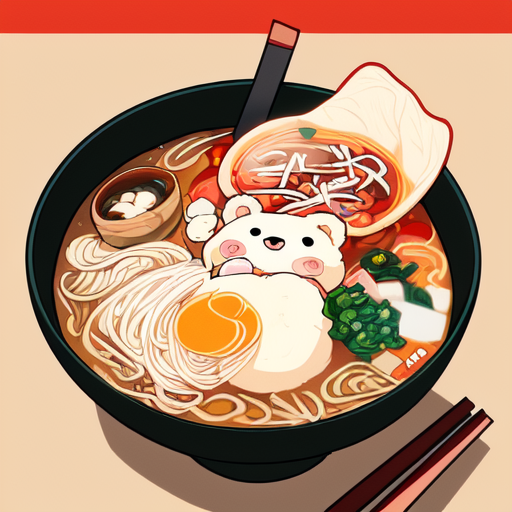

In [2]:
import torch
from diffusers import DiffusionPipeline

pipeline = DiffusionPipeline.from_pretrained(
    "nqzfaizal77ai/austersight-exp-sd-1.5",
    torch_dtype=torch.float16
).to(t_device)
pipeline.load_lora_weights(
    "nqzfaizal77ai/busipa-sd-1.5-lora",
    adapter_name="busipa"
)
pipeline.load_lora_weights(
    "nqzfaizal77ai/sibear-sd-1.5-lora",
    adapter_name="sibear"
)
pipeline.set_adapters(["busipa", "sibear"], adapter_weights=[0.7, 0.8])

pipeline.fuse_lora(adapter_names=["busipa", "sibear"], lora_scale=1.0)

pipeline("A bowl of ramen shaped like a cute kawaii bear, by Feng Zikai").images[0]

In [6]:
del pipeline

import torch

import gc
gc.collect()
torch.cuda.empty_cache()